# Computational Astrophysics
## Elliptic PDEs. Examples

---
## Eduard Larrañaga

Observatorio Astronómico Nacional\
Facultad de Ciencias\
Universidad Nacional de Colombia

---

### About this notebook

In this notebook we present some of the techniques used to solve the Poisson equation.

`A. Garcia. Numerical Methods for Physics. (1999). Chapter 6 - 7 `

---

##  Poisson Equation as an ODE Example. Pre-Supernova Model

A supernova is a process in which a dying star liberates a huge quantity of energy and mass.
 In this section we will solve Poisson equation to obtain the gravitational potential inside the mass distribution of a dying star.
 
In the data file `presupernovaStar.dat` we find the information of a pre-supernova stellar model. The columns in this file are:


1. First column: grid point index
2. Second column: enclosed mass of the star ($\text{gr}$)
3. Third column: radius of the distribution ($\text{cm}$)
4. Fourth column: temperature ($\text{K}$)
5. Fifth column: mass density ($\text{gr/cm}^3$)

**The other columns in the data file are not important for this exercise**

First, we will read the data and make a plot of some of the variables in order to visualize the information.

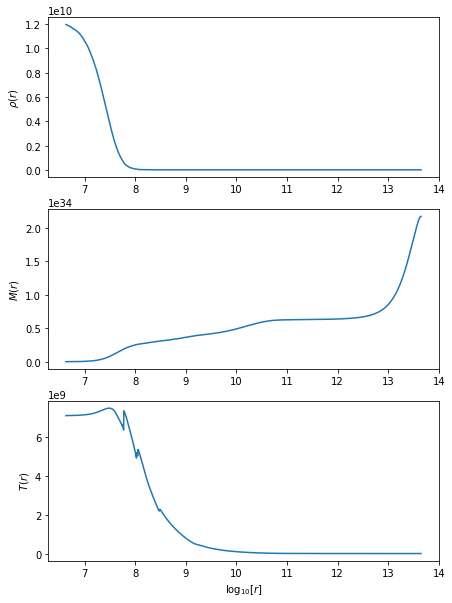

In [36]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Load data of rho vs. radius
(index, mass, dataradius, temperature, density, var1, var2, var3) = np.loadtxt('presupernovaStar.dat', unpack = True)

fig, ax = plt.subplots(3,1, figsize=(7,10))
ax[0].plot(np.log10(dataradius), density)
ax[0].set_ylabel(r'$\rho (r)$')
                 
ax[1].plot(np.log10(dataradius), mass)
ax[1].set_ylabel(r'$M (r)$')

ax[2].plot(np.log10(dataradius), temperature)
ax[2].set_ylabel(r'$T (r)$')
ax[2].set_xlabel(r'$\log_{10} [r]$')

plt.show()

The first radius in the data file is

In [40]:
dataradius[0]

4296013.288986084

---

We will restrict the data from this value up to a radius of $r < 10^9 \,\mathrm{cm}$. Hence we will define an equidistant grid and we will interpolate the values of the density in this grid using the function `numpy.interp()`.

Information of this function can be found at
https://numpy.org/doc/stable/reference/generated/numpy.interp.html

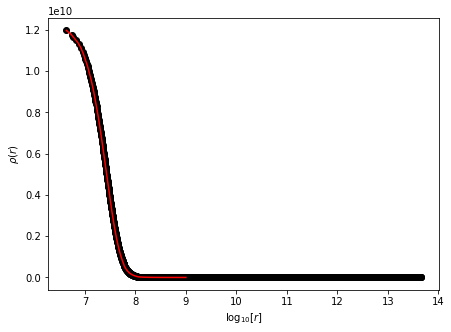

In [41]:
# Equidistant grid definition
n = 1000
r_0 = dataradius[0]
r_f = 1e9
radius = np.linspace(r_0, r_f, n)

# Interpolation of the density in the equidistant grid
rho = np.interp(radius, dataradius, density)

# Plot of the data points together with the interpolated density
plt.figure(figsize=(7,5))
plt.scatter(np.log10(dataradius), density, color='black')
plt.plot(np.log10(radius), rho, 'r')

plt.xlabel(r'$\log_{10} [r]$')
plt.ylabel(r'$\rho(r)$')
plt.show()

Now that we have the interpolated density, we implement the solution of the Poisson equation with the ODE method.

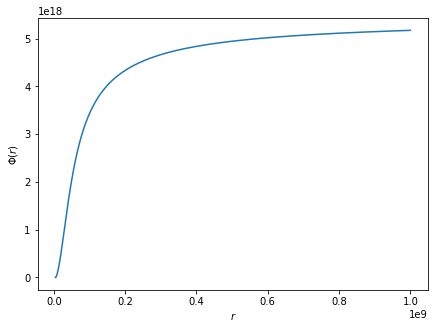

In [42]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


# Global constants (cgs units)
G = 6.67e-8

# ODE definition
def ODE(r, q0, rho0):
    '''
    ------------------------------------------
    ODE(r,q0) 
    ------------------------------------------
    ODEs system for the Poisson Equation
    Arguments:
    r: radius
    q0: numpy array with the initial condition
        data:
        q0[0] = Phi
        q0[1] = dPhi/dr
    ------------------------------------------
    '''
    Phi = q0[0]
    z = q0[1]
    f = np.zeros(2)
    f[0] = z
    f[1] = 4*np.pi*G*rho0 - 2*z/r
    return f

def FEuler(h, r0, q0, rho0):
    '''
    ------------------------------------------
    FEuler(h, r0, q0, rho0)
    ------------------------------------------
    Forward Euler's method for solving a ODEs 
    system.
    Arguments:
    h: stepsize for the iteration
    r0: independent parameter initial value
    q0: numpy array with the initial values of
        the functions in the ODEs system
    ------------------------------------------
    '''
    f = ODE(r0, q0, rho0)
    q1 = q0 + h*f
    return q1

# Constant stepsize defined by the number of steps in the grid
h = radius[1] - radius[0]

# Arrays to store the solution
Q = np.zeros([2,n]) # Euler's Method information

# Initial Conditions
Q[0,0] = 0. # Initial guess for the value of the potential at the center 
Q[1,0] = 0. # Derivative of the potential at the center


# Main loops for solving the problem
for i in range(1,n):
    q0 = Q[:,i-1]
    qf = FEuler(h, radius[i-1], q0, rho[i-1])
    Q[:,i] = qf[:]


plt.figure(figsize=(7,5))
plt.plot(radius,Q[0])
plt.xlabel(r'$r$')
plt.ylabel(r'$\Phi(r)$')
plt.show()

---

## Poisson Equation solved by the Matrix Method. Homogenoeous Sphere

In the matrix method, the Poisson Equation is discretized with centered differences. Imposing the boundary condition $\frac{\partial \Phi}{ \partial r} = 0$ gives

\begin{equation}
\Phi_{-1} = \Phi_{0}\,\,.
\end{equation}

Then, the Poisson equation is written as linear system

\begin{equation}
J \mathbf{\Phi} = \mathbf{b}\,\,,
\label{eq:pde_poisson2}
\end{equation}

where $\Phi$ = $(\Phi_0, \cdots , \Phi_{n-1})^T$ (for a grid with $n$
points labeled $0$ to $n-1$) and  $\mathbf{b} = 4\pi G
(\rho_0, \cdots , \rho_{n-1})^T$. 


The matrix $J$ has tri-diagonal form and can be explicitely given as

1. $i=j=0$:
\begin{equation}
J_{00} = - \frac{1}{(\Delta r)^2} - \frac{1}{r_0 \Delta r}\,\,,
\end{equation}

2. $i=j$:
\begin{equation}
J_{ij} = \frac{-2}{(\Delta r)^2}\,\,,
\end{equation}

3. $i+1=j$:
\begin{equation}
J_{ij} = \frac{1}{(\Delta r)^2} + \frac{1}{r_i \Delta r}\,\,,
\end{equation}

4. $i-1=j$:
\begin{equation}
J_{ij} = \frac{1}{(\Delta r)^2} - \frac{1}{r_i \Delta r}\,\,.
\end{equation}

Now we solve the pre-spuernova stellar model problem using this description. 

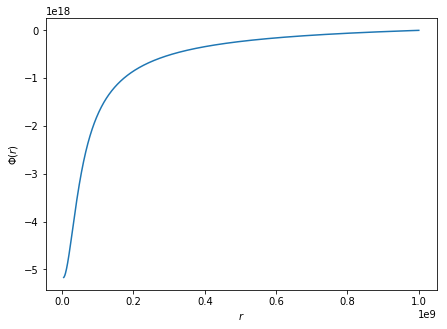

In [44]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Global constants (cgs units)
G = 6.67e-8

# Constant stepsize defined by the number of steps in the grid
dr = radius[1] - radius[0]

b = 4*np.pi*G*rho
J = np.zeros([n,n])

# Definition of the matrix J
J[0,0] = -1/dr**2 - 1/(dr*radius[0])

for i in range(1,n):
    J[i,i] = -2/dr**2
    J[i,i-1] = 1/dr**2 - 1/(dr*radius[i])

for i in range(0,n-1):
    J[i,i+1] = 1/dr**2 + 1/(dr*radius[i])


# Forward Elimination
d = np.zeros(n)
w = np.zeros(n)

d[0] = J[0,0]
w[0] = b[0]/d[0]

for i in range(1,n):
    d[i] = J[i,i] - J[i,i-1]*J[i-1,i]/d[i-1]
    w[i] = (b[i] - w[i-1]*J[i,i-1])/d[i]


# Back-Substitution
y = np.zeros(n)

y[-1] = w[-1]
for i in range(n-2,-1,-1):
    y[i] = w[i] - y[i+1]*J[i,i+1]/d[i]

    

plt.figure(figsize=(7,5))
plt.plot(radius, y)
plt.xlabel(r'$r$')
plt.ylabel(r'$\Phi(r)$')
plt.show()
